In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels import api as sm
from xgboost import XGBRegressor
from pygam import ExpectileGAM
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
np.random.seed(42)


In [2]:
# Load data_daily files
data_folder = Path("data")

data_daily_A = pd.read_csv(data_folder / 'data_daily_A.csv', index_col=0, parse_dates=True)
data_daily_B = pd.read_csv(data_folder / 'data_daily_B.csv', index_col=0, parse_dates=True)
data_daily_C = pd.read_csv(data_folder / 'data_daily_C.csv', index_col=0, parse_dates=True)


print("Data loaded successfully!")
print(f"data_daily_A: {data_daily_A.shape}")
print(f"data_daily_B: {data_daily_B.shape}")
print(f"data_daily_C: {data_daily_C.shape}")

Data loaded successfully!
data_daily_A: (755, 2)
data_daily_B: (739, 2)
data_daily_C: (737, 2)


# A

In [3]:
# Check data shapes
print("Data shapes:")
print(f"data_daily_A: {data_daily_A.shape}")
print(f"data_daily_B: {data_daily_B.shape}")
print(f"data_daily_C: {data_daily_C.shape}")
print("\nFirst few rows of data_daily_A:")
print(data_daily_A.head())

Data shapes:
data_daily_A: (755, 2)
data_daily_B: (739, 2)
data_daily_C: (737, 2)

First few rows of data_daily_A:
            log_sales_A  log_sell_price_A
date                                     
2019-01-01     2.995732          4.423528
2019-01-02     3.737670          4.423528
2019-01-03     4.204693          4.423528
2019-01-04     4.356709          4.423528
2019-01-05     4.356709          4.423528


In [4]:
# ============================================================================
# SLIDING WINDOW OLS REGRESSION FOR PRODUCT A - DAILY DATA
# ============================================================================
# This cell implements a sliding window cross-validation approach for OLS 
# regression on daily data. It creates multiple train-test splits with fixed
# window sizes (180 days training, 7 days testing) that move forward by 1 day
# each iteration. Daily data provides more granular price elasticity analysis
# compared to weekly aggregation.

# ============================================================================
# Data Preparation
# ============================================================================
# Copy data for Product A and extract date index
data = data_daily_A.copy()
dates = data.index.to_numpy()  # Convert index to numpy array for indexing

# Define feature (independent variable) and target (dependent variable)
feature = 'log_sell_price_A'  # Price elasticity measured through log price
target = 'log_sales_A'  # Sales volume measured as log quantity

# ============================================================================
# Sliding Window Parameters
# ============================================================================
# Window sizes are proportional to daily data (vs. 26 weeks/4 weeks for weekly)
train_window = 180  # Training window: 180 days (~6 months)
test_window = 7     # Test window: 7 days (1 week)

results = []  # Store regression results from each window

# ============================================================================
# Sliding Window Loop
# ============================================================================
# Creates overlapping train-test splits that move forward one day at a time
for i in range(len(dates) - train_window - test_window + 1):
    # Calculate index boundaries for this iteration
    train_start_idx = i  # Starting index of training window
    train_end_idx = i + train_window - 1  # Ending index of training window
    test_start_idx = i + train_window  # Starting index of test window
    test_end_idx = i + train_window + test_window - 1  # Ending index of test window
    
    # Extract data for this window using positional indices
    train_data = data.iloc[train_start_idx:train_end_idx+1]  # iloc: inclusive of train_end_idx
    test_data = data.iloc[test_start_idx:test_end_idx+1]
    
    # Skip if either window is empty (shouldn't occur with proper indexing)
    if len(train_data) == 0 or len(test_data) == 0:
        continue
    
    # Extract feature and target as numpy arrays, flatten to 1D
    # .flatten() converts 2D array to 1D array (required for OLS)
    X_train = train_data[[feature]].values.flatten()
    y_train = train_data[target].values.flatten()
    X_test = test_data[[feature]].values.flatten()
    y_test = test_data[target].values.flatten()
    
    # ========================================================================
    # Data Quality Check
    # ========================================================================
    # Skip windows with missing values (NaN) which would break regression
    if np.isnan(X_train).any() or np.isnan(y_train).any() or np.isnan(X_test).any() or np.isnan(y_test).any():
        continue
    
    # ========================================================================
    # OLS Regression with Manual Constant Addition
    # ========================================================================
    # Note: Manual constant stacking avoids shape mismatch errors from sm.add_constant()
    # Create constant column (all ones) and stack with feature column
    X_train_sm = np.column_stack([np.ones(len(X_train)), X_train])  # Shape: (n, 2) [intercept, price]
    
    # Fit OLS model on training data using statsmodels
    # y = intercept + coefficient * X
    model = sm.OLS(y_train, X_train_sm).fit()  # OLS: Ordinary Least Squares
    
    # Prepare test data in same format as training data (constant + feature)
    X_test_sm = np.column_stack([np.ones(len(X_test)), X_test])
    
    # Generate predictions on test set
    y_pred = model.predict(X_test_sm)
    
    # ========================================================================
    # Performance Metrics Calculation
    # ========================================================================
    # Calculate three standard regression metrics for this window
    mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error: average absolute deviation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE: penalizes large errors more
    r2 = r2_score(y_test, y_pred)  # R² Score: proportion of variance explained (can be negative)
    
    # ========================================================================
    # Store Window Results
    # ========================================================================
    results.append({
        'Window': i + 1,  # Window number (1-indexed)
        'Train_Start': dates[train_start_idx],  # Training period start date
        'Train_End': dates[train_end_idx],  # Training period end date
        'Test_Start': dates[test_start_idx],  # Testing period start date
        'Test_End': dates[test_end_idx],  # Testing period end date
        'Train_Size': len(train_data),  # Number of days in training window
        'Test_Size': len(test_data),  # Number of days in test window
        'Coef': model.params[1],  # Regression coefficient (price elasticity)
        'Intercept': model.params[0],  # Regression intercept (baseline sales)
        'MAE': mae,  # Mean Absolute Error
        'RMSE': rmse,  # Root Mean Squared Error
        'R2': r2  # R² Score
    })

# ============================================================================
# Create Summary Results
# ============================================================================
# Convert list of dictionaries to pandas DataFrame for analysis
results_df = pd.DataFrame(results)

# Print summary statistics
print("SLIDING WINDOW OLS REGRESSION RESULTS FOR PRODUCT A")
print(f"Windows generated: {len(results_df)}")  # Total number of valid windows
print(f"Mean MAE: {results_df['MAE'].mean():.4f}, Mean RMSE: {results_df['RMSE'].mean():.4f}, Mean R²: {results_df['R2'].mean():.4f}")

SLIDING WINDOW OLS REGRESSION RESULTS FOR PRODUCT A
Windows generated: 569
Mean MAE: 0.3125, Mean RMSE: 0.3766, Mean R²: -1.0380


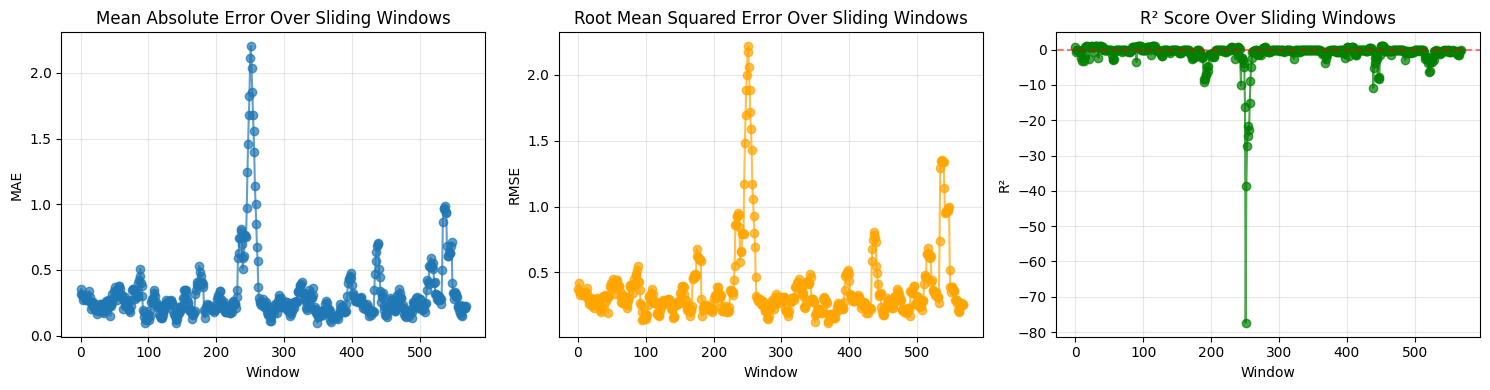

In [5]:
# Visualize OLS Results for Product A
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(results_df['MAE'], marker='o', label='MAE', alpha=0.7)
axes[0].set_ylabel('MAE')
axes[0].set_xlabel('Window')
axes[0].set_title('Mean Absolute Error Over Sliding Windows')
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_df['RMSE'], marker='o', label='RMSE', alpha=0.7, color='orange')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Window')
axes[1].set_title('Root Mean Squared Error Over Sliding Windows')
axes[1].grid(True, alpha=0.3)

axes[2].plot(results_df['R2'], marker='o', label='R²', alpha=0.7, color='green')
axes[2].set_ylabel('R²')
axes[2].set_xlabel('Window')
axes[2].set_title('R² Score Over Sliding Windows')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [6]:
# ============================================================================
# SLIDING WINDOW XGBoost REGRESSION FOR PRODUCT A - DAILY DATA
# ============================================================================
# This cell implements XGBoost (gradient boosting) using the same sliding
# window cross-validation approach as OLS. XGBoost is a non-linear ensemble
# method that can capture complex, non-linear relationships between price
# and sales that linear models might miss.

results_xgb = []  # Store XGBoost results from each window

# ============================================================================
# Sliding Window Loop
# ============================================================================
# Creates overlapping train-test splits that move forward one day at a time
for i in range(len(dates) - train_window - test_window + 1):
    # Calculate index boundaries for this iteration
    train_start_idx = i  # Starting index of training window
    train_end_idx = i + train_window - 1  # Ending index of training window
    test_start_idx = i + train_window  # Starting index of test window
    test_end_idx = i + train_window + test_window - 1  # Ending index of test window
    
    # Extract data for this window using positional indices
    train_data = data.iloc[train_start_idx:train_end_idx+1]
    test_data = data.iloc[test_start_idx:test_end_idx+1]
    
    # Skip if either window is empty
    if len(train_data) == 0 or len(test_data) == 0:
        continue
    
    # Extract feature and target as numpy arrays (XGBoost prefers arrays over DataFrames)
    # Note: No need to flatten arrays for XGBoost (unlike OLS)
    X_train = train_data[[feature]].values  # Shape: (n, 1) - 2D array for XGBoost
    y_train = train_data[target].values  # Shape: (n,) - 1D array
    X_test = test_data[[feature]].values
    y_test = test_data[target].values
    
    # ========================================================================
    # XGBoost Regression Model
    # ========================================================================
    # Initialize XGBoost regressor with hyperparameters
    # - n_estimators: 100 boosting rounds (number of decision trees)
    # - learning_rate: 0.1 (shrinkage factor, lower = more conservative)
    # - max_depth: 4 (tree depth limits, prevents overfitting)
    # - random_state: 42 (ensures reproducibility across runs)
    model_xgb = XGBRegressor(
        n_estimators=100,  # Number of boosting rounds (trees)
        learning_rate=0.1,  # Learning rate (shrinkage factor)
        max_depth=4,  # Maximum tree depth
        random_state=42  # Random seed for reproducibility
    )
    
    # Fit the XGBoost model on training data
    # XGBoost builds an ensemble of decision trees, each correcting errors from previous trees
    model_xgb.fit(X_train, y_train)
    
    # Generate predictions on test set
    y_pred_xgb = model_xgb.predict(X_test)
    
    # ========================================================================
    # Performance Metrics Calculation
    # ========================================================================
    # Calculate three standard regression metrics for this window
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)  # Mean Absolute Error
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))  # Root Mean Squared Error
    r2_xgb = r2_score(y_test, y_pred_xgb)  # R² Score (can be negative for poor models)
    
    # ========================================================================
    # Store Window Results
    # ========================================================================
    results_xgb.append({
        'Window': i + 1,  # Window number (1-indexed)
        'Train_Start': dates[train_start_idx],  # Training period start date
        'Train_End': dates[train_end_idx],  # Training period end date
        'Test_Start': dates[test_start_idx],  # Testing period start date
        'Test_End': dates[test_end_idx],  # Testing period end date
        'Train_Size': len(train_data),  # Number of days in training window
        'Test_Size': len(test_data),  # Number of days in test window
        'MAE': mae_xgb,  # Mean Absolute Error
        'RMSE': rmse_xgb,  # Root Mean Squared Error
        'R2': r2_xgb  # R² Score
    })

# ============================================================================
# Create Summary Results
# ============================================================================
# Convert list of dictionaries to pandas DataFrame for analysis
results_xgb_df = pd.DataFrame(results_xgb)

# Print summary statistics
print("SLIDING WINDOW XGBoost REGRESSION RESULTS FOR PRODUCT A")
print(f"Windows generated: {len(results_xgb_df)}")  # Total number of valid windows
print(f"Mean MAE: {results_xgb_df['MAE'].mean():.4f}, Mean RMSE: {results_xgb_df['RMSE'].mean():.4f}, Mean R²: {results_xgb_df['R2'].mean():.4f}")

SLIDING WINDOW XGBoost REGRESSION RESULTS FOR PRODUCT A
Windows generated: 569
Mean MAE: 0.3118, Mean RMSE: 0.3774, Mean R²: -1.3924


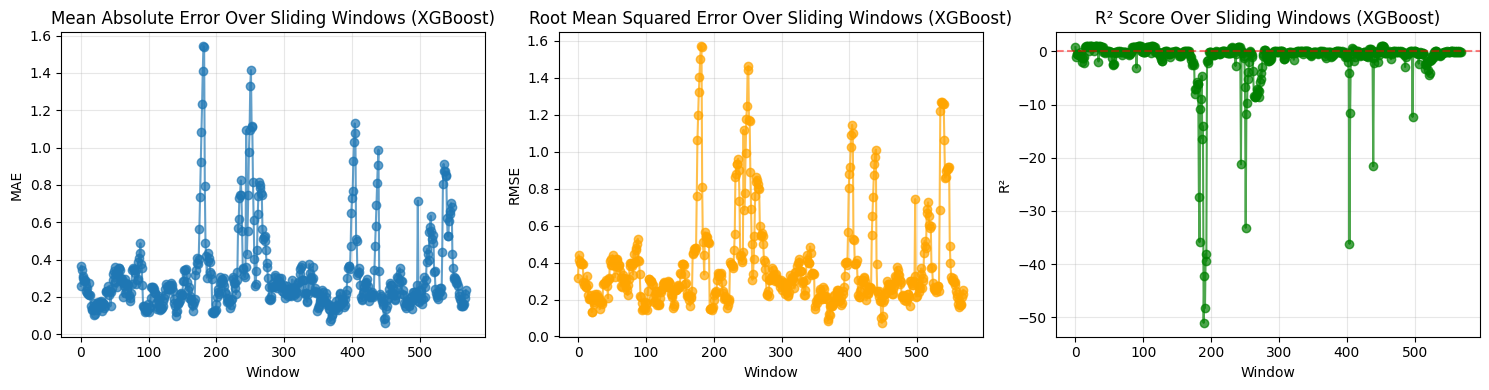

In [7]:
# Visualize XGBoost Results for Product A
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(results_xgb_df['MAE'], marker='o', label='MAE', alpha=0.7)
axes[0].set_ylabel('MAE')
axes[0].set_xlabel('Window')
axes[0].set_title('Mean Absolute Error Over Sliding Windows (XGBoost)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(results_xgb_df['RMSE'], marker='o', label='RMSE', alpha=0.7, color='orange')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Window')
axes[1].set_title('Root Mean Squared Error Over Sliding Windows (XGBoost)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(results_xgb_df['R2'], marker='o', label='R²', alpha=0.7, color='green')
axes[2].set_ylabel('R²')
axes[2].set_xlabel('Window')
axes[2].set_title('R² Score Over Sliding Windows (XGBoost)')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [8]:
# ============================================================================
# SLIDING WINDOW PyGAM QUANTILE REGRESSION FOR PRODUCT A - DAILY DATA
# ============================================================================
# This cell implements PyGAM (Generalized Additive Models) with quantile
# regression using the ExpectileGAM estimator. Unlike OLS (mean) and XGBoost,
# PyGAM with quantiles estimates different quantiles of the conditional
# distribution, providing confidence intervals (lower, median, upper bounds).
# This is useful for understanding the range of possible sales values at
# different price levels.

# ============================================================================
# Quantile Definition
# ============================================================================
# Define three quantiles to estimate for confidence interval visualization:
# - 0.025 (2.5%): Lower bound - 95% of values expected to be above this
# - 0.5 (50%): Median - the typical/central prediction
# - 0.975 (97.5%): Upper bound - 95% of values expected to be below this
# Together, these create a 95% confidence band around the median prediction
quantiles = [0.025, 0.5, 0.975]

# Dictionary to store results dataframes for each quantile
results_pygam_dfs = {}

# ============================================================================
# Quantile Loop - Fit separate model for each quantile
# ============================================================================
for q in quantiles:
    # Initialize list to store results for this specific quantile
    results_pygam = []
    
    # ====================================================================
    # Sliding Window Loop
    # ====================================================================
    # Creates overlapping train-test splits that move forward one day at a time
    for i in range(len(dates) - train_window - test_window + 1):
        # Calculate index boundaries for this iteration
        train_start_idx = i  # Starting index of training window
        train_end_idx = i + train_window - 1  # Ending index of training window
        test_start_idx = i + train_window  # Starting index of test window
        test_end_idx = i + train_window + test_window - 1  # Ending index of test window
        
        # Extract data for this window using positional indices
        train_data = data.iloc[train_start_idx:train_end_idx+1]
        test_data = data.iloc[test_start_idx:test_end_idx+1]
        
        # Skip if either window is empty
        if len(train_data) == 0 or len(test_data) == 0:
            continue
        
        # Extract feature and target as numpy arrays
        X_train = train_data[[feature]].values  # Shape: (n, 1) - 2D array
        y_train = train_data[target].values  # Shape: (n,) - 1D array
        X_test = test_data[[feature]].values
        y_test = test_data[target].values
        
        # ====================================================================
        # PyGAM Quantile Regression (ExpectileGAM)
        # ====================================================================
        # Initialize ExpectileGAM with specific quantile (expectile parameter)
        # ExpectileGAM approximates quantile regression using expectiles
        # which are a generalization of quantiles with better computational properties
        model_pygam = ExpectileGAM(expectile=q)
        
        # Fit the model on training data
        # PyGAM fits a smooth, non-parametric curve through the data
        # The smoothness is controlled by splines and regularization
        model_pygam.fit(X_train, y_train)
        
        # Generate predictions on test set for this specific quantile
        y_pred_pygam = model_pygam.predict(X_test)
        
        # ====================================================================
        # Performance Metrics Calculation
        # ====================================================================
        # Calculate three standard regression metrics for this window and quantile
        mae_pygam = mean_absolute_error(y_test, y_pred_pygam)  # Mean Absolute Error
        rmse_pygam = np.sqrt(mean_squared_error(y_test, y_pred_pygam))  # Root Mean Squared Error
        r2_pygam = r2_score(y_test, y_pred_pygam)  # R² Score
        
        # ====================================================================
        # Store Window Results
        # ====================================================================
        results_pygam.append({
            'Window': i + 1,  # Window number (1-indexed)
            'Train_Start': dates[train_start_idx],  # Training period start date
            'Train_End': dates[train_end_idx],  # Training period end date
            'Test_Start': dates[test_start_idx],  # Testing period start date
            'Test_End': dates[test_end_idx],  # Testing period end date
            'Train_Size': len(train_data),  # Number of days in training window
            'Test_Size': len(test_data),  # Number of days in test window
            'MAE': mae_pygam,  # Mean Absolute Error
            'RMSE': rmse_pygam,  # Root Mean Squared Error
            'R2': r2_pygam  # R² Score
        })
    
    # ========================================================================
    # Create Summary Results for This Quantile
    # ========================================================================
    # Convert list of dictionaries to pandas DataFrame for this quantile
    results_pygam_dfs[q] = pd.DataFrame(results_pygam)
    
    # Print summary statistics for this quantile
    print(f"SLIDING WINDOW PyGAM (Q={q}) REGRESSION FOR PRODUCT A")
    print(f"Windows generated: {len(results_pygam_dfs[q])}")  # Total number of valid windows
    print(f"Mean MAE: {results_pygam_dfs[q]['MAE'].mean():.4f}, Mean RMSE: {results_pygam_dfs[q]['RMSE'].mean():.4f}, Mean R²: {results_pygam_dfs[q]['R2'].mean():.4f}\n")

SLIDING WINDOW PyGAM (Q=0.025) REGRESSION FOR PRODUCT A
Windows generated: 569
Mean MAE: 0.6031, Mean RMSE: 0.6577, Mean R²: -9.4463

SLIDING WINDOW PyGAM (Q=0.5) REGRESSION FOR PRODUCT A
Windows generated: 569
Mean MAE: 0.2891, Mean RMSE: 0.3513, Mean R²: -0.7947

SLIDING WINDOW PyGAM (Q=0.975) REGRESSION FOR PRODUCT A
Windows generated: 569
Mean MAE: 0.4528, Mean RMSE: 0.5258, Mean R²: -3.8700



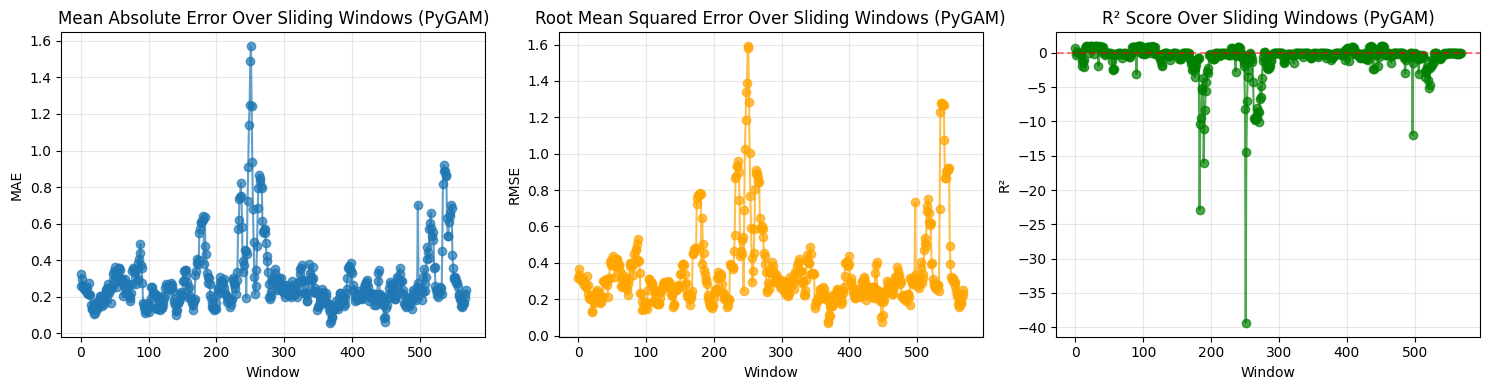

In [9]:
# Visualize PyGAM Results for Product A
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

q_median = results_pygam_dfs[0.5]

axes[0].plot(q_median['MAE'], marker='o', label='MAE', alpha=0.7)
axes[0].set_ylabel('MAE')
axes[0].set_xlabel('Window')
axes[0].set_title('Mean Absolute Error Over Sliding Windows (PyGAM)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(q_median['RMSE'], marker='o', label='RMSE', alpha=0.7, color='orange')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Window')
axes[1].set_title('Root Mean Squared Error Over Sliding Windows (PyGAM)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(q_median['R2'], marker='o', label='R²', alpha=0.7, color='green')
axes[2].set_ylabel('R²')
axes[2].set_xlabel('Window')
axes[2].set_title('R² Score Over Sliding Windows (PyGAM)')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# B

In [10]:
data_daily_B.head()

,log_sales_B,log_sell_price_B
date,,
2019-01-01,1.945910,3.61604
2019-01-02,3.178054,3.61604
2019-01-03,3.637586,3.61604
2019-01-04,3.091042,3.61604
2019-01-05,3.218876,3.61604


In [11]:
# ============================================================================
# SLIDING WINDOW REGRESSION FOR PRODUCT B - DAILY DATA (OLS & XGBoost)
# ============================================================================
# This cell implements sliding window cross-validation for both OLS (Ordinary
# Least Squares) linear regression and XGBoost (gradient boosting) on Product B
# daily price elasticity data. Both models use the same sliding windows
# (180-day training, 7-day testing) to ensure fair comparison of their
# predictive performance on the same data splits.

# ============================================================================
# Data Preparation for Product B
# ============================================================================
# Copy Product B data and extract date index for time-series tracking
data_B = data_daily_B.copy()
dates_B = data_B.index.to_numpy()  # Convert index to numpy array for indexing

# Define feature and target variables specific to Product B
feature_B = 'log_sell_price_B'  # Log price - independent variable
target_B = 'log_sales_B'  # Log sales - dependent variable to predict

# Initialize result storage lists for both models
results_B = []  # Store OLS regression results from each window
results_B_xgb = []  # Store XGBoost regression results from each window

# ============================================================================
# Sliding Window Loop - OLS and XGBoost (Parallel Processing)
# ============================================================================
# Both models use identical train-test splits (180 days training, 7 days testing)
# moving forward one day at a time for consistent comparison

for i in range(len(dates_B) - train_window - test_window + 1):
    # ====================================================================
    # Window Index Calculation
    # ====================================================================
    # Define boundary indices for this iteration's train-test split
    train_start_idx = i  # Starting index of training window
    train_end_idx = i + train_window - 1  # Ending index of training window (180 days)
    test_start_idx = i + train_window  # Starting index of test window
    test_end_idx = i + train_window + test_window - 1  # Ending index of test window (7 days)
    
    # ====================================================================
    # Data Extraction
    # ====================================================================
    # Extract subsets of data for this specific window
    train_data = data_B.iloc[train_start_idx:train_end_idx+1]  # Training subset
    test_data = data_B.iloc[test_start_idx:test_end_idx+1]  # Testing subset
    
    # Skip this iteration if windows are invalid (shouldn't occur with proper indexing)
    if len(train_data) == 0 or len(test_data) == 0:
        continue
    
    # ====================================================================
    # OLS Data Preparation
    # ====================================================================
    # Extract OLS features and targets, flattening to 1D arrays
    X_train = train_data[[feature_B]].values.flatten()  # Training prices (1D)
    y_train = train_data[target_B].values.flatten()  # Training sales (1D)
    X_test = test_data[[feature_B]].values.flatten()  # Test prices (1D)
    y_test = test_data[target_B].values.flatten()  # Test sales (1D)
    
    # ====================================================================
    # Data Quality Check
    # ====================================================================
    # Skip windows with missing values (NaN) that would break regression
    if np.isnan(X_train).any() or np.isnan(y_train).any() or np.isnan(X_test).any() or np.isnan(y_test).any():
        continue
    
    # ====================================================================
    # OLS Regression with Manual Constant Addition
    # ====================================================================
    # Create constant column (all ones) and stack with feature column
    # This avoids shape mismatch errors that occur with sm.add_constant()
    X_train_sm = np.column_stack([np.ones(len(X_train)), X_train])  # Shape: (180, 2) [intercept, price]
    
    # Fit OLS model: y = intercept + coefficient * X
    model = sm.OLS(y_train, X_train_sm).fit()
    
    # Prepare test data in identical format for prediction
    X_test_sm = np.column_stack([np.ones(len(X_test)), X_test])
    
    # Generate predictions on test set
    y_pred = model.predict(X_test_sm)
    
    # ====================================================================
    # OLS Performance Metrics
    # ====================================================================
    mae = mean_absolute_error(y_test, y_pred)  # Average absolute deviation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Penalizes large errors
    r2 = r2_score(y_test, y_pred)  # Variance explained (can be negative)
    
    # ====================================================================
    # Store OLS Window Results
    # ====================================================================
    results_B.append({
        'Window': i + 1,  # Window number (1-indexed for readability)
        'Train_Start': dates_B[train_start_idx],  # Training period start date
        'Train_End': dates_B[train_end_idx],  # Training period end date
        'Test_Start': dates_B[test_start_idx],  # Testing period start date
        'Test_End': dates_B[test_end_idx],  # Testing period end date
        'Train_Size': len(train_data),  # Number of days in training window (should be 180)
        'Test_Size': len(test_data),  # Number of days in test window (should be 7)
        'Coef': model.params[1],  # Price elasticity coefficient (effect of price on sales)
        'Intercept': model.params[0],  # Baseline sales (intercept)
        'MAE': mae,  # Mean Absolute Error
        'RMSE': rmse,  # Root Mean Squared Error
        'R2': r2  # R² Score
    })
    
    # ====================================================================
    # XGBoost Data Preparation
    # ====================================================================
    # Extract XGBoost features and targets as 2D/1D arrays (no flattening needed)
    X_train_xgb = train_data[[feature_B]].values  # Shape: (180, 1)
    y_train_xgb = train_data[target_B].values  # Shape: (180,)
    X_test_xgb = test_data[[feature_B]].values  # Shape: (7, 1)
    y_test_xgb = test_data[target_B].values  # Shape: (7,)
    
    # ====================================================================
    # XGBoost Regression Model
    # ====================================================================
    # Initialize XGBoost regressor with hyperparameters
    model_xgb = XGBRegressor(
        n_estimators=100,  # Number of boosting rounds (decision trees)
        learning_rate=0.1,  # Shrinkage factor (lower = more conservative training)
        max_depth=4,  # Maximum tree depth (limits complexity, prevents overfitting)
        random_state=42  # Random seed for reproducibility
    )
    
    # Fit XGBoost on training data
    # XGBoost builds ensemble of trees, each correcting errors from previous trees
    model_xgb.fit(X_train_xgb, y_train_xgb)
    
    # Generate predictions on test set
    y_pred_xgb = model_xgb.predict(X_test_xgb)
    
    # ====================================================================
    # XGBoost Performance Metrics
    # ====================================================================
    mae_xgb = mean_absolute_error(y_test_xgb, y_pred_xgb)  # Average absolute deviation
    rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))  # Penalizes large errors
    r2_xgb = r2_score(y_test_xgb, y_pred_xgb)  # Variance explained (can be negative)
    
    # ====================================================================
    # Store XGBoost Window Results
    # ====================================================================
    results_B_xgb.append({
        'Window': i + 1,  # Window number (1-indexed)
        'MAE': mae_xgb,  # Mean Absolute Error
        'RMSE': rmse_xgb,  # Root Mean Squared Error
        'R2': r2_xgb  # R² Score
    })

# ============================================================================
# Create Summary DataFrames and Print Results
# ============================================================================
# Convert lists of results to pandas DataFrames for analysis
results_B_df = pd.DataFrame(results_B)
results_B_xgb_df = pd.DataFrame(results_B_xgb)

# Print summary statistics for both models
print("SLIDING WINDOW REGRESSION RESULTS FOR PRODUCT B")
print(f"OLS - Windows: {len(results_B_df)}, Mean MAE: {results_B_df['MAE'].mean():.4f}, Mean R²: {results_B_df['R2'].mean():.4f}")
print(f"XGBoost - Windows: {len(results_B_xgb_df)}, Mean MAE: {results_B_xgb_df['MAE'].mean():.4f}, Mean R²: {results_B_xgb_df['R2'].mean():.4f}")


SLIDING WINDOW REGRESSION RESULTS FOR PRODUCT B
OLS - Windows: 553, Mean MAE: 0.3930, Mean R²: -1.3939
XGBoost - Windows: 553, Mean MAE: 0.3687, Mean R²: -1.3624


In [ ]:
# ============================================================================
# SLIDING WINDOW PyGAM QUANTILE REGRESSION FOR PRODUCT B - DAILY DATA
# ============================================================================
# This cell implements PyGAM (Generalized Additive Models) with quantile
# regression using the ExpectileGAM estimator for Product B. Unlike OLS (mean)
# and XGBoost, PyGAM with quantiles estimates different quantiles of the 
# conditional distribution, providing confidence intervals (lower, median, 
# upper bounds). This is useful for understanding the range of possible sales 
# values at different price levels.

# ============================================================================
# Quantile Definition
# ============================================================================
# Define three quantiles to estimate for confidence interval visualization:
# - 0.025 (2.5%): Lower bound - 95% of values expected to be above this
# - 0.5 (50%): Median - the typical/central prediction
# - 0.975 (97.5%): Upper bound - 95% of values expected to be below this
# Together, these create a 95% confidence band around the median prediction

# Dictionary to store results dataframes for each quantile
results_B_pygam_dfs = {}

# ============================================================================
# Quantile Loop - Fit separate model for each quantile
# ============================================================================
for q in quantiles:
    # Initialize list to store results for this specific quantile
    results_B_pygam = []
    
    # ====================================================================
    # Sliding Window Loop
    # ====================================================================
    # Creates overlapping train-test splits that move forward one day at a time
    for i in range(len(dates_B) - train_window - test_window + 1):
        # Calculate index boundaries for this iteration
        train_start_idx = i  # Starting index of training window
        train_end_idx = i + train_window - 1  # Ending index of training window
        test_start_idx = i + train_window  # Starting index of test window
        test_end_idx = i + train_window + test_window - 1  # Ending index of test window
        
        # Extract data for this window using positional indices
        train_data = data_B.iloc[train_start_idx:train_end_idx+1]  # Training subset
        test_data = data_B.iloc[test_start_idx:test_end_idx+1]  # Testing subset
        
        # Skip if either window is empty
        if len(train_data) == 0 or len(test_data) == 0:
            continue
        
        # Extract feature and target as numpy arrays
        X_train = train_data[[feature_B]].values  # Shape: (n, 1) - 2D array
        y_train = train_data[target_B].values  # Shape: (n,) - 1D array
        X_test = test_data[[feature_B]].values  # Shape: (n, 1)
        y_test = test_data[target_B].values  # Shape: (n,)
        
        # ====================================================================
        # PyGAM Quantile Regression (ExpectileGAM)
        # ====================================================================
        # Initialize ExpectileGAM with specific quantile (expectile parameter)
        # ExpectileGAM approximates quantile regression using expectiles
        # which are a generalization of quantiles with better computational properties
        model_pygam = ExpectileGAM(expectile=q)
        
        # Fit the model on training data
        # PyGAM fits a smooth, non-parametric curve through the data
        # The smoothness is controlled by splines and regularization
        model_pygam.fit(X_train, y_train)
        
        # Generate predictions on test set for this specific quantile
        y_pred_pygam = model_pygam.predict(X_test)
        
        # ====================================================================
        # Performance Metrics Calculation
        # ====================================================================
        # Calculate three standard regression metrics for this window and quantile
        mae_pygam = mean_absolute_error(y_test, y_pred_pygam)  # Mean Absolute Error
        rmse_pygam = np.sqrt(mean_squared_error(y_test, y_pred_pygam))  # Root Mean Squared Error
        r2_pygam = r2_score(y_test, y_pred_pygam)  # R² Score
        
        # ====================================================================
        # Store Window Results
        # ====================================================================
        results_B_pygam.append({
            'Window': i + 1,  # Window number (1-indexed)
            'MAE': mae_pygam,  # Mean Absolute Error
            'RMSE': rmse_pygam,  # Root Mean Squared Error
            'R2': r2_pygam  # R² Score
        })
    
    # ========================================================================
    # Create Summary Results for This Quantile
    # ========================================================================
    # Convert list of dictionaries to pandas DataFrame for this quantile
    results_B_pygam_dfs[q] = pd.DataFrame(results_B_pygam)
    
    # Print summary statistics for this quantile
    print(f"PyGAM (Q={q}) - Windows: {len(results_B_pygam_dfs[q])}, Mean MAE: {results_B_pygam_dfs[q]['MAE'].mean():.4f}, Mean R²: {results_B_pygam_dfs[q]['R2'].mean():.4f}")

PyGAM (Q=0.025) - Windows: 553, Mean MAE: 0.6179, Mean R²: -4.8780
PyGAM (Q=0.5) - Windows: 553, Mean MAE: 0.3559, Mean R²: -1.1412
PyGAM (Q=0.975) - Windows: 553, Mean MAE: 0.6326, Mean R²: -8.3058


# C

In [ ]:
# ============================================================================
# SLIDING WINDOW REGRESSION FOR PRODUCT C - DAILY DATA (OLS & XGBoost)
# ============================================================================
# This cell implements sliding window cross-validation for both OLS (Ordinary
# Least Squares) linear regression and XGBoost (gradient boosting) on Product C
# daily price elasticity data. Both models use the same sliding windows
# (180-day training, 7-day testing) to ensure fair comparison of their
# predictive performance on the same data splits.

# ============================================================================
# Data Preparation for Product C
# ============================================================================
# Copy Product C data and extract date index for time-series tracking
data_C = data_daily_C.copy()
dates_C = data_C.index.to_numpy()  # Convert index to numpy array for indexing

# Define feature and target variables specific to Product C
feature_C = 'log_sell_price_C'  # Log price - independent variable
target_C = 'log_sales_C'  # Log sales - dependent variable to predict

# Initialize result storage lists for both models
results_C = []  # Store OLS regression results from each window
results_C_xgb = []  # Store XGBoost regression results from each window

# ============================================================================
# Sliding Window Loop - OLS and XGBoost
# ============================================================================
# Creates overlapping train-test splits that move forward one day at a time
# Both models use identical window boundaries (180 days training, 7 days testing)
for i in range(len(dates_C) - train_window - test_window + 1):
    # ====================================================================
    # Window Index Calculation
    # ====================================================================
    # Define boundary indices for this iteration's train-test split
    train_start_idx = i  # Starting index of training window
    train_end_idx = i + train_window - 1  # Ending index of training window (180 days)
    test_start_idx = i + train_window  # Starting index of test window
    test_end_idx = i + train_window + test_window - 1  # Ending index of test window (7 days)
    
    # ====================================================================
    # Data Extraction
    # ====================================================================
    # Extract subsets of data for this specific window
    train_data = data_C.iloc[train_start_idx:train_end_idx+1]  # Training subset (180 days)
    test_data = data_C.iloc[test_start_idx:test_end_idx+1]  # Testing subset (7 days)
    
    # Skip this iteration if windows are invalid (shouldn't occur with proper indexing)
    if len(train_data) == 0 or len(test_data) == 0:
        continue
    
    # ====================================================================
    # OLS Data Preparation
    # ====================================================================
    # Extract OLS features and targets, flattening to 1D arrays
    # OLS requires 1D arrays for both features and targets
    X_train = train_data[[feature_C]].values.flatten()  # Training prices (1D array)
    y_train = train_data[target_C].values.flatten()  # Training sales (1D array)
    X_test = test_data[[feature_C]].values.flatten()  # Test prices (1D array)
    y_test = test_data[target_C].values.flatten()  # Test sales (1D array)
    
    # ====================================================================
    # Data Quality Check
    # ====================================================================
    # Skip windows with missing values (NaN) that would break regression
    if np.isnan(X_train).any() or np.isnan(y_train).any() or np.isnan(X_test).any() or np.isnan(y_test).any():
        continue
    
    # ====================================================================
    # OLS Regression with Manual Constant Addition
    # ====================================================================
    # Create constant column (all ones) and stack with feature column
    # This avoids shape mismatch errors that occur with sm.add_constant()
    X_train_sm = np.column_stack([np.ones(len(X_train)), X_train])  # Shape: (180, 2) [intercept, price]
    
    # Fit OLS model on training data using statsmodels
    # Model equation: y = intercept + coefficient * X
    model = sm.OLS(y_train, X_train_sm).fit()  # OLS: Ordinary Least Squares regression
    
    # Prepare test data in identical format for prediction
    X_test_sm = np.column_stack([np.ones(len(X_test)), X_test])  # Shape: (7, 2)
    
    # Generate predictions on test set using fitted OLS model
    y_pred = model.predict(X_test_sm)
    
    # ====================================================================
    # OLS Performance Metrics Calculation
    # ====================================================================
    mae = mean_absolute_error(y_test, y_pred)  # Mean Absolute Error: average absolute deviation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE: penalizes large errors more heavily
    r2 = r2_score(y_test, y_pred)  # R² Score: proportion of variance explained (can be negative)
    
    # ====================================================================
    # Store OLS Window Results
    # ====================================================================
    results_C.append({
        'Window': i + 1,  # Window number (1-indexed for readability)
        'Train_Start': dates_C[train_start_idx],  # Training period start date
        'Train_End': dates_C[train_end_idx],  # Training period end date
        'Test_Start': dates_C[test_start_idx],  # Testing period start date
        'Test_End': dates_C[test_end_idx],  # Testing period end date
        'Train_Size': len(train_data),  # Number of days in training window (should be 180)
        'Test_Size': len(test_data),  # Number of days in test window (should be 7)
        'Coef': model.params[1],  # Price elasticity coefficient (effect of price on sales)
        'Intercept': model.params[0],  # Baseline sales level (intercept)
        'MAE': mae,  # Mean Absolute Error
        'RMSE': rmse,  # Root Mean Squared Error
        'R2': r2  # R² Score
    })
    
    # ====================================================================
    # XGBoost Data Preparation
    # ====================================================================
    # Extract XGBoost features and targets as 2D/1D arrays (no flattening needed for XGBoost)
    X_train_xgb = train_data[[feature_C]].values  # Shape: (180, 1) - 2D array for XGBoost
    y_train_xgb = train_data[target_C].values  # Shape: (180,) - 1D array
    X_test_xgb = test_data[[feature_C]].values  # Shape: (7, 1)
    y_test_xgb = test_data[target_C].values  # Shape: (7,)
    
    # ====================================================================
    # XGBoost Regression Model
    # ====================================================================
    # Initialize XGBoost regressor with hyperparameters
    # - n_estimators: 100 boosting rounds (number of sequential decision trees)
    # - learning_rate: 0.1 (shrinkage factor, lower = more conservative training)
    # - max_depth: 4 (maximum tree depth, limits complexity and prevents overfitting)
    # - random_state: 42 (random seed ensures reproducibility across runs)
    model_xgb = XGBRegressor(
        n_estimators=100,  # Number of boosting rounds (sequential trees)
        learning_rate=0.1,  # Shrinkage factor (learning rate)
        max_depth=4,  # Maximum tree depth (model complexity control)
        random_state=42  # Random seed for reproducibility
    )
    
    # Fit XGBoost on training data
    # XGBoost builds an ensemble of decision trees sequentially
    # Each tree corrects errors made by previous trees
    model_xgb.fit(X_train_xgb, y_train_xgb)
    
    # Generate predictions on test set using fitted XGBoost model
    y_pred_xgb = model_xgb.predict(X_test_xgb)
    
    # ====================================================================
    # XGBoost Performance Metrics Calculation
    # ====================================================================
    mae_xgb = mean_absolute_error(y_test_xgb, y_pred_xgb)  # Mean Absolute Error
    rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))  # Root Mean Squared Error
    r2_xgb = r2_score(y_test_xgb, y_pred_xgb)  # R² Score (can be negative for poor models)
    
    # ====================================================================
    # Store XGBoost Window Results
    # ====================================================================
    results_C_xgb.append({
        'Window': i + 1,  # Window number (1-indexed)
        'MAE': mae_xgb,  # Mean Absolute Error
        'RMSE': rmse_xgb,  # Root Mean Squared Error
        'R2': r2_xgb  # R² Score
    })

# ============================================================================
# Create Summary DataFrames and Print Results
# ============================================================================
# Convert lists of results to pandas DataFrames for analysis
results_C_df = pd.DataFrame(results_C)  # OLS results DataFrame
results_C_xgb_df = pd.DataFrame(results_C_xgb)  # XGBoost results DataFrame

# Print summary statistics for both models
print("SLIDING WINDOW REGRESSION RESULTS FOR PRODUCT C")
print(f"OLS - Windows: {len(results_C_df)}, Mean MAE: {results_C_df['MAE'].mean():.4f}, Mean R²: {results_C_df['R2'].mean():.4f}")
print(f"XGBoost - Windows: {len(results_C_xgb_df)}, Mean MAE: {results_C_xgb_df['MAE'].mean():.4f}, Mean R²: {results_C_xgb_df['R2'].mean():.4f}")

SLIDING WINDOW REGRESSION RESULTS FOR PRODUCT C
OLS - Windows: 551, Mean MAE: 0.5243, Mean R²: -7.1639
XGBoost - Windows: 551, Mean MAE: 0.4758, Mean R²: -4.8199


In [ ]:
# ============================================================================
# SLIDING WINDOW PyGAM QUANTILE REGRESSION FOR PRODUCT C - DAILY DATA
# ============================================================================
# This cell implements PyGAM (Generalized Additive Models) with quantile
# regression using the ExpectileGAM estimator for Product C. Unlike OLS (mean)
# and XGBoost, PyGAM with quantiles estimates different quantiles of the 
# conditional distribution, providing confidence intervals (lower, median, 
# upper bounds). This is useful for understanding the range of possible sales 
# values at different price levels.

# ============================================================================
# Quantile Definition and Storage
# ============================================================================
# Dictionary to store results dataframes for each quantile
# The quantiles list was defined earlier in the notebook
results_C_pygam_dfs = {}

# ============================================================================
# Quantile Loop - Fit separate model for each quantile
# ============================================================================
# For each quantile (0.025, 0.5, 0.975), fit separate PyGAM models
for q in quantiles:
    # Initialize list to store results for this specific quantile
    results_C_pygam = []
    
    # ====================================================================
    # Sliding Window Loop
    # ====================================================================
    # Creates overlapping train-test splits that move forward one day at a time
    for i in range(len(dates_C) - train_window - test_window + 1):
        # Calculate index boundaries for this iteration
        train_start_idx = i  # Starting index of training window
        train_end_idx = i + train_window - 1  # Ending index of training window
        test_start_idx = i + train_window  # Starting index of test window
        test_end_idx = i + train_window + test_window - 1  # Ending index of test window
        
        # Extract data for this window using positional indices
        train_data = data_C.iloc[train_start_idx:train_end_idx+1]  # Training subset
        test_data = data_C.iloc[test_start_idx:test_end_idx+1]  # Testing subset
        
        # Skip if either window is empty
        if len(train_data) == 0 or len(test_data) == 0:
            continue
        
        # Extract feature and target as numpy arrays
        X_train = train_data[[feature_C]].values  # Shape: (n, 1) - 2D array
        y_train = train_data[target_C].values  # Shape: (n,) - 1D array
        X_test = test_data[[feature_C]].values  # Shape: (n, 1)
        y_test = test_data[target_C].values  # Shape: (n,)
        
        # ====================================================================
        # PyGAM Quantile Regression (ExpectileGAM)
        # ====================================================================
        # Initialize ExpectileGAM with specific quantile (expectile parameter)
        # ExpectileGAM approximates quantile regression using expectiles
        # which are a generalization of quantiles with better computational properties
        model_pygam = ExpectileGAM(expectile=q)
        
        # Fit the model on training data
        # PyGAM fits a smooth, non-parametric curve through the data
        # The smoothness is controlled by splines and regularization
        model_pygam.fit(X_train, y_train)
        
        # Generate predictions on test set for this specific quantile
        y_pred_pygam = model_pygam.predict(X_test)
        
        # ====================================================================
        # Performance Metrics Calculation
        # ====================================================================
        # Calculate three standard regression metrics for this window and quantile
        mae_pygam = mean_absolute_error(y_test, y_pred_pygam)  # Mean Absolute Error
        rmse_pygam = np.sqrt(mean_squared_error(y_test, y_pred_pygam))  # Root Mean Squared Error
        r2_pygam = r2_score(y_test, y_pred_pygam)  # R² Score
        
        # ====================================================================
        # Store Window Results
        # ====================================================================
        results_C_pygam.append({
            'Window': i + 1,  # Window number (1-indexed)
            'MAE': mae_pygam,  # Mean Absolute Error
            'RMSE': rmse_pygam,  # Root Mean Squared Error
            'R2': r2_pygam  # R² Score
        })
    
    # ========================================================================
    # Create Summary Results for This Quantile
    # ========================================================================
    # Convert list of dictionaries to pandas DataFrame for this quantile
    results_C_pygam_dfs[q] = pd.DataFrame(results_C_pygam)
    
    # Print summary statistics for this quantile
    print(f"PyGAM (Q={q}) - Windows: {len(results_C_pygam_dfs[q])}, Mean MAE: {results_C_pygam_dfs[q]['MAE'].mean():.4f}, Mean R²: {results_C_pygam_dfs[q]['R2'].mean():.4f}")

PyGAM (Q=0.025) - Windows: 551, Mean MAE: 0.8741, Mean R²: -19.9699
PyGAM (Q=0.5) - Windows: 551, Mean MAE: 0.4671, Mean R²: -4.2248
PyGAM (Q=0.975) - Windows: 551, Mean MAE: 0.4768, Mean R²: -4.1836


# Comparison & Summary

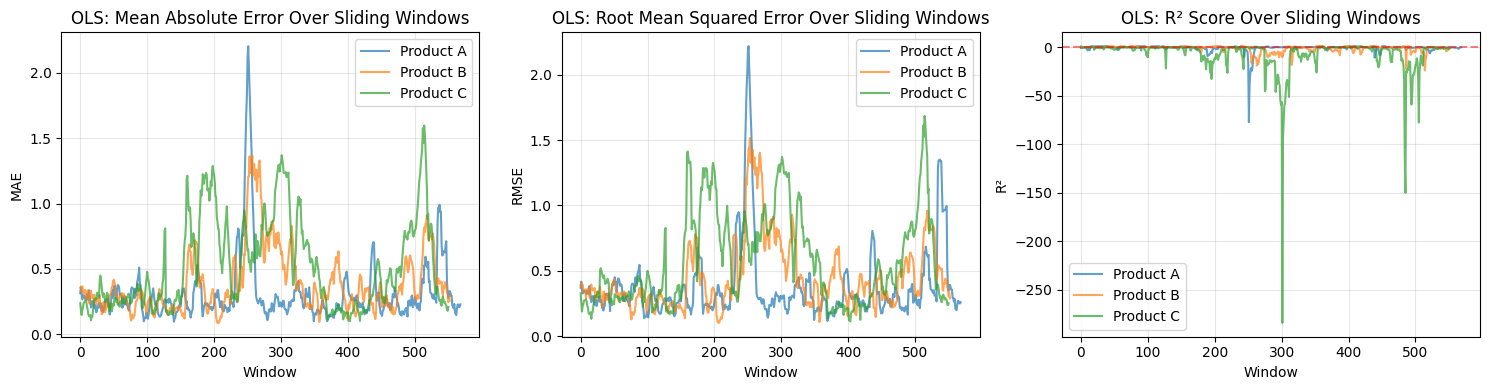

In [23]:
# OLS Comparison across all products
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Compare MAE
for df, label in [(results_df, 'A'), (results_B_df, 'B'), (results_C_df, 'C')]:
    if len(df) > 0:
        axes[0].plot(df['MAE'], label=f'Product {label}', alpha=0.7)
axes[0].set_ylabel('MAE')
axes[0].set_xlabel('Window')
axes[0].set_title('OLS: Mean Absolute Error Over Sliding Windows')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Compare RMSE
for df, label in [(results_df, 'A'), (results_B_df, 'B'), (results_C_df, 'C')]:
    if len(df) > 0:
        axes[1].plot(df['RMSE'], label=f'Product {label}', alpha=0.7)
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Window')
axes[1].set_title('OLS: Root Mean Squared Error Over Sliding Windows')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Compare R²
for df, label in [(results_df, 'A'), (results_B_df, 'B'), (results_C_df, 'C')]:
    if len(df) > 0:
        axes[2].plot(df['R2'], label=f'Product {label}', alpha=0.7)
axes[2].set_ylabel('R²')
axes[2].set_xlabel('Window')
axes[2].set_title('OLS: R² Score Over Sliding Windows')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

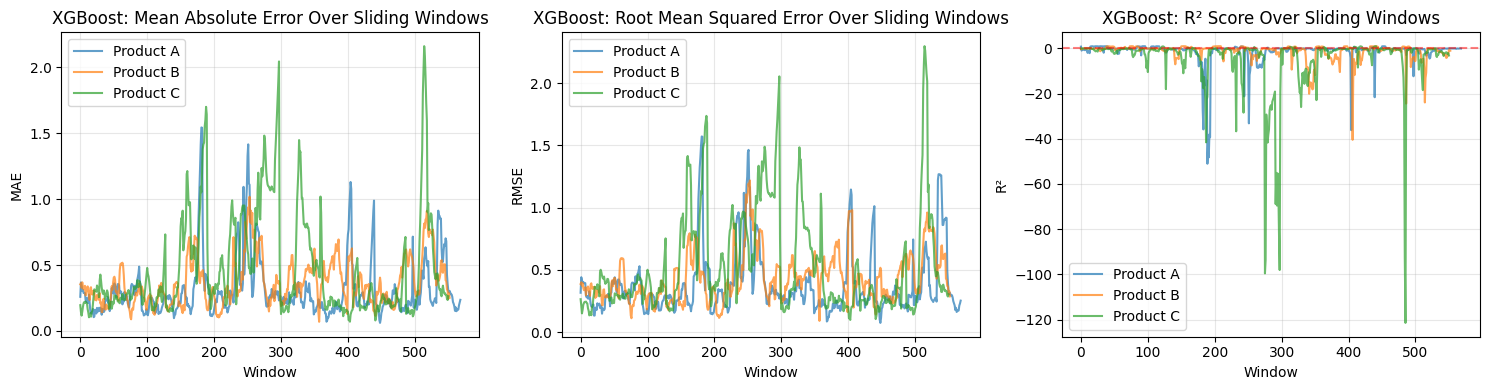

In [24]:
# XGBoost Comparison across all products
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Compare MAE
for df, label in [(results_xgb_df, 'A'), (results_B_xgb_df, 'B'), (results_C_xgb_df, 'C')]:
    if len(df) > 0:
        axes[0].plot(df['MAE'], label=f'Product {label}', alpha=0.7)
axes[0].set_ylabel('MAE')
axes[0].set_xlabel('Window')
axes[0].set_title('XGBoost: Mean Absolute Error Over Sliding Windows')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Compare RMSE
for df, label in [(results_xgb_df, 'A'), (results_B_xgb_df, 'B'), (results_C_xgb_df, 'C')]:
    if len(df) > 0:
        axes[1].plot(df['RMSE'], label=f'Product {label}', alpha=0.7)
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Window')
axes[1].set_title('XGBoost: Root Mean Squared Error Over Sliding Windows')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Compare R²
for df, label in [(results_xgb_df, 'A'), (results_B_xgb_df, 'B'), (results_C_xgb_df, 'C')]:
    if len(df) > 0:
        axes[2].plot(df['R2'], label=f'Product {label}', alpha=0.7)
axes[2].set_ylabel('R²')
axes[2].set_xlabel('Window')
axes[2].set_title('XGBoost: R² Score Over Sliding Windows')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [25]:
# Summary Table
summary_data = []

for product, ols_df, xgb_df, pygam_dfs in [
    ('A', results_df, results_xgb_df, results_pygam_dfs),
    ('B', results_B_df, results_B_xgb_df, results_B_pygam_dfs),
    ('C', results_C_df, results_C_xgb_df, results_C_pygam_dfs)
]:
    # OLS
    if len(ols_df) > 0:
        summary_data.append({
            'Product': product,
            'Model': 'OLS',
            'Mean_MAE': ols_df['MAE'].mean(),
            'Mean_RMSE': ols_df['RMSE'].mean(),
            'Mean_R2': ols_df['R2'].mean()
        })
    
    # XGBoost
    if len(xgb_df) > 0:
        summary_data.append({
            'Product': product,
            'Model': 'XGBoost',
            'Mean_MAE': xgb_df['MAE'].mean(),
            'Mean_RMSE': xgb_df['RMSE'].mean(),
            'Mean_R2': xgb_df['R2'].mean()
        })
    
    # PyGAM (Q=0.5)
    if 0.5 in pygam_dfs and len(pygam_dfs[0.5]) > 0:
        pygam_df = pygam_dfs[0.5]
        summary_data.append({
            'Product': product,
            'Model': 'PyGAM (Q=0.5)',
            'Mean_MAE': pygam_df['MAE'].mean(),
            'Mean_RMSE': pygam_df['RMSE'].mean(),
            'Mean_R2': pygam_df['R2'].mean()
        })

summary_df = pd.DataFrame(summary_data)
print("\n=== SUMMARY TABLE (Daily Data) ===")
print(summary_df.to_string(index=False))


=== SUMMARY TABLE (Daily Data) ===
Product         Model  Mean_MAE  Mean_RMSE   Mean_R2
      A           OLS  0.312527   0.376647 -1.037986
      A       XGBoost  0.311765   0.377435 -1.392353
      A PyGAM (Q=0.5)  0.289066   0.351296 -0.794706
      B           OLS  0.392986   0.455114 -1.393928
      B       XGBoost  0.368664   0.442880 -1.362414
      B PyGAM (Q=0.5)  0.355864   0.423910 -1.141169
      C           OLS  0.524296   0.580388 -7.163867
      C       XGBoost  0.475765   0.542534 -4.819862
      C PyGAM (Q=0.5)  0.467136   0.533321 -4.224826


# Daily Data Analysis Results - 7-Day Testing Window

## 1. OLS Comparison Across All Products

- **MAE (Left)**: Product A has the lowest error (~0.31), followed by Product B (~0.39), while Product C shows higher variability (~0.52)
- **RMSE (Center)**: Similar pattern with Product A most stable, Product C most volatile
- **R² Score (Right)**: All products show mostly negative R² values, with Product C showing extreme negative spikes down to -250, indicating poor predictive performance

## 2. XGBoost Comparison Across All Products

- **MAE (Left)**: Product A (~0.31) and B (~0.37) perform well, Product C (~0.48) worse
- **RMSE (Center)**: Consistent with MAE, Product C more volatile
- **R² Score (Right)**: Product A and B relatively stable around -1 to -5, Product C highly volatile with spikes below -100

## Summary Table - Daily Data (7-day Testing Window)

| Product | Model | Mean MAE | Mean RMSE | Mean R² |
|---------|-------|----------|-----------|---------|
| A | OLS | 0.3125 | 0.3766 | -1.0380 |
| A | XGBoost | 0.3118 | 0.3774 | -1.3924 |
| A | PyGAM (Q=0.5) | 0.2891 | 0.3513 | -0.7947 |
| B | OLS | 0.3930 | 0.4551 | -1.3939 |
| B | XGBoost | 0.3687 | 0.4429 | -1.3624 |
| B | PyGAM (Q=0.5) | 0.3559 | 0.4239 | -1.1412 |
| C | OLS | 0.5243 | 0.5804 | -7.1639 |
| C | XGBoost | 0.4758 | 0.5425 | -4.8199 |
| C | PyGAM (Q=0.5) | 0.4671 | 0.5333 | -4.2248 |

## Key Findings

- **Product A** performs best across all models with PyGAM achieving lowest MAE (0.289)
- **Product B** shows moderate performance with XGBoost slightly better than OLS
- **Product C** most challenging with negative R² values around -4 to -7, suggesting single-feature models struggle with this product
- **PyGAM (median quantile)** generally outperforms linear OLS and XGBoost in terms of MAE

# Modeling Points
* The models behave similar in terms of R^2, MAE and RMSE
* Though the average R^2 is negative which suggests that a simple mean is good enough
* It is moreso due to outliers/volatility
* We will stick to simple OLS for better explainability and mathematical convenience